Import Dependencies

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import windrose
from scipy.stats import zscore
from windrose import WindroseAxes
from scipy import stats
import os

# Load the dataset

In [10]:
df = pd.read_csv('../data/togo-dapaong_qc.csv', parse_dates=['Timestamp'])

# Summary Statistics

In [11]:
print(f"\n📍 togo")
    
# Summary stats
print("\n📊 Summary Statistics:")
display(df.describe())


📍 togo

📊 Summary Statistics:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-04-25 12:00:30.000000768,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
min,2021-10-25 00:01:00,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,2022-01-24 06:00:45,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2022-04-25 12:00:30,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,2022-07-25 18:00:15,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,2022-10-25 00:00:00,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN
std,NaN,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN


# Missing value detection and handling

In [12]:
print("\n❓ Missing Value Count:")
missing = df.isna().sum()
display(missing[missing > 0])

# Identify columns with >5% missing values
total = len(df)
high_nulls = missing[missing > 0][missing / total > 0.05]
if not high_nulls.empty:
    print("\n⚠️ Columns with >5% missing values:")
    display(high_nulls)
else:
    print("\n✅ No columns with >5% missing values.")


❓ Missing Value Count:


Comments    525600
dtype: int64


⚠️ Columns with >5% missing values:


Comments    525600
dtype: int64

# Outlier Detection(Z-score) and Basic cleaning

In [13]:
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
# 2. Check and handle missing values in key columns
missing_before = df[columns_to_check].isnull().sum()
print("Missing before imputation:\n", missing_before)


#drop column
# null_col = df['Comments'].isna().all()
# print(f"Is comments null?{null_col}")
# df.drop(columns=["Comments"], inplace=True)


# Impute missing values using median
for col in columns_to_check:
    df[col] = df[col].fillna(df[col].median())

# 3. Compute Z-scores
z_scores = df[columns_to_check].apply(zscore)

# 4. Identify rows with any z-score > 3 (or < -3)
outliers = (z_scores.abs() > 3).any(axis=1)
print(f"Outliers detected: {outliers.sum()} rows")

# 5. Remove outlier rows
df_cleaned = df[~outliers].copy()

# 6. Final check
print(f"Cleaned shape: {df_cleaned.shape}")

# 7. Save cleaned data
os.makedirs('data', exist_ok=True)
df_cleaned.to_csv(f"../data/togo-dapaong_qc_clean.csv", index=False)

print(f"togo-dapaong_qc_clean.csv saved.\n")

Missing before imputation:
 GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Outliers detected: 9251 rows
Cleaned shape: (516349, 19)
togo-dapaong_qc_clean.csv saved.



# Time Series Analysis

# Load the cleaned csv

In [14]:
df = pd.read_csv("../data/togo-dapaong_qc_clean.csv", parse_dates=['Timestamp'])

# Ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Create time-based columns
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour


# Daily Trend Plot Hourly Mean

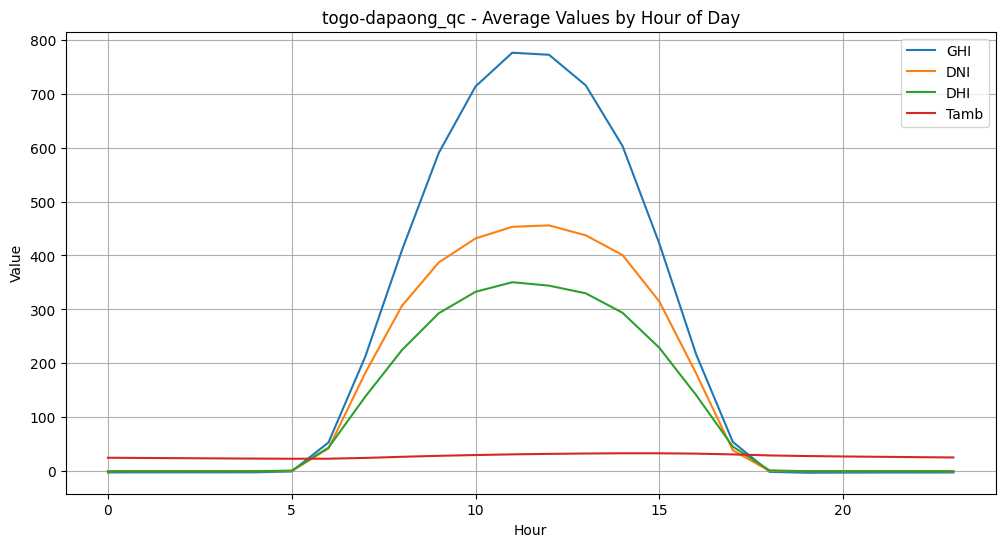

In [15]:
hourly_mean = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_mean)
plt.title("togo-dapaong_qc - Average Values by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Value")
plt.legend(['GHI', 'DNI', 'DHI', 'Tamb'])
plt.grid(True)
plt.show()

# Monthly Trend Plot

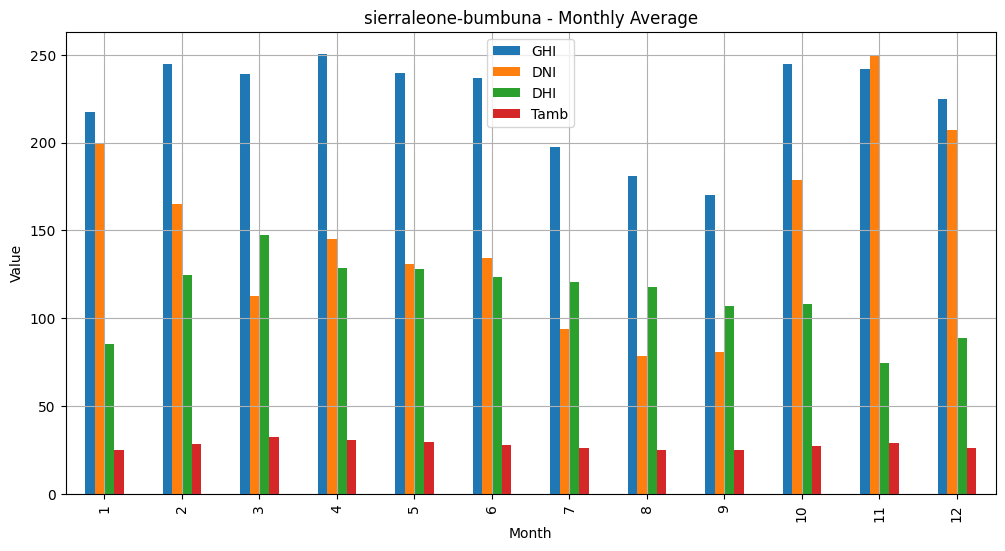

In [ ]:
monthly_mean = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

monthly_mean.plot(kind='bar', figsize=(12, 6))
plt.title("togo-dapaong_qc - Monthly Average")
plt.xlabel("Month")
plt.ylabel("Value")
plt.grid(True)
plt.legend(['GHI', 'DNI', 'DHI', 'Tamb'])
plt.show()


# Identifying Anomalies

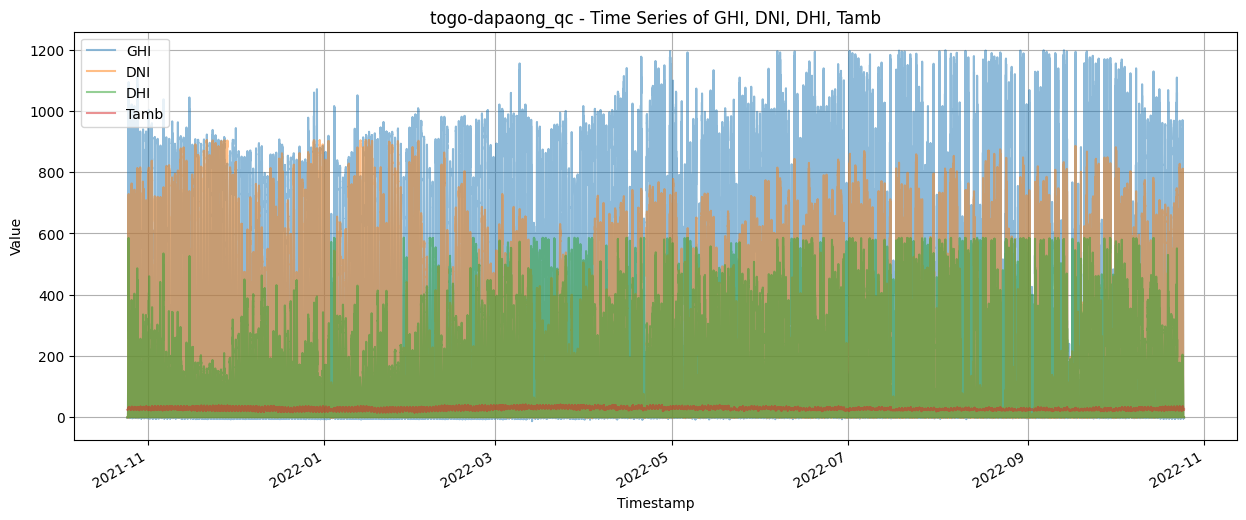

In [17]:
df.set_index('Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].plot(figsize=(15, 6), alpha=0.5)
plt.title("togo-dapaong_qc - Time Series of GHI, DNI, DHI, Tamb")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Impact of Cleaning

In [18]:
# Example for one city, repeat for all three
df = pd.read_csv("../data/sierraleone-bumbuna_clean.csv")

cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
print(cleaning_impact)

                ModA        ModB
Cleaning                        
0         189.680780  181.598521
1         273.309252  277.231102


# Plotting a comparison

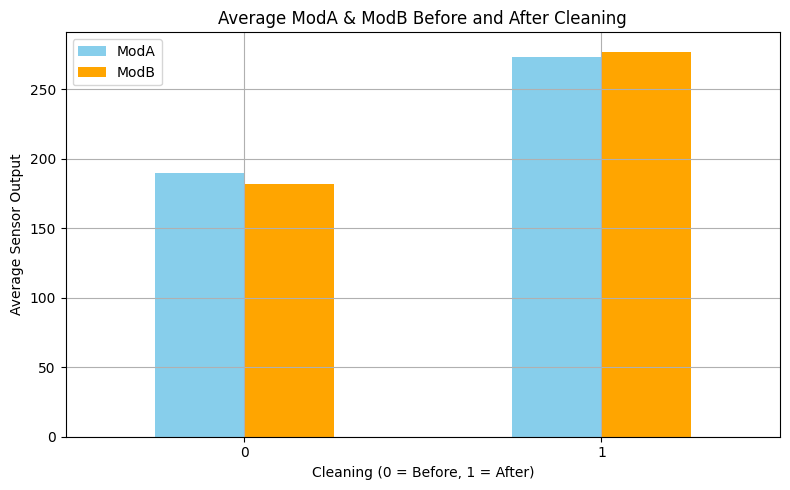

In [19]:
cleaning_impact.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'orange'])
plt.title("Average ModA & ModB Before and After Cleaning")
plt.xlabel("Cleaning (0 = Before, 1 = After)")
plt.ylabel("Average Sensor Output")
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(["ModA", "ModB"])
plt.tight_layout()
plt.show()

# Correlation & Relationship Analysis 

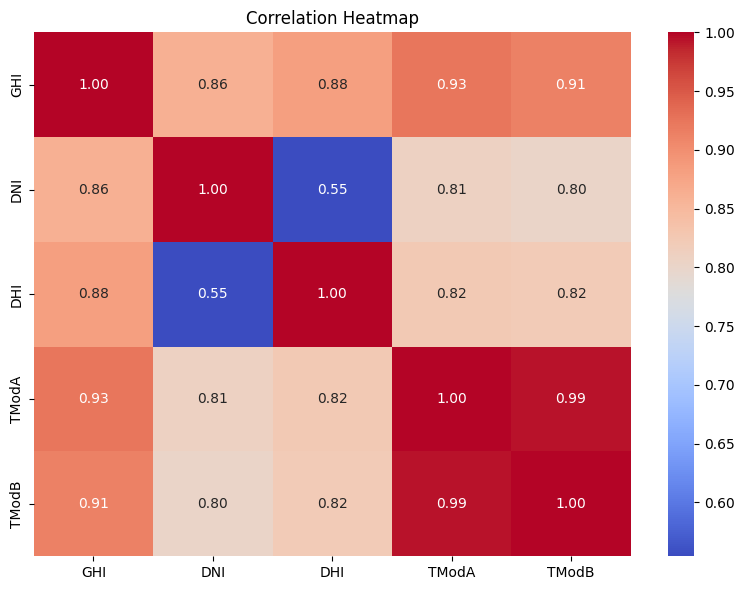

In [20]:
df = pd.read_csv("../data/sierraleone-bumbuna_clean.csv")

# Subset of relevant columns
columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
correlation_matrix = df[columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Scatter plots

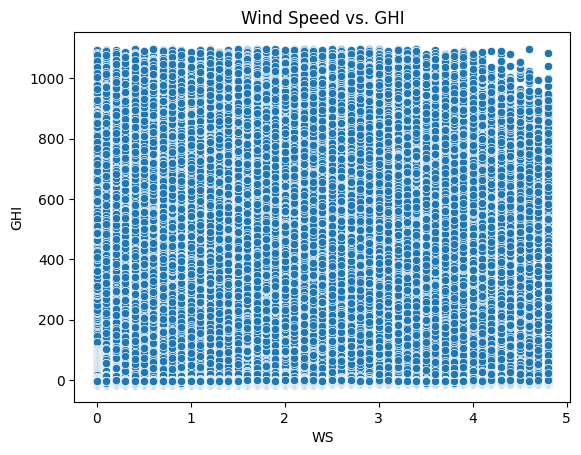

In [21]:
sns.scatterplot(data=df, x='WS', y='GHI')
plt.title('Wind Speed vs. GHI')
plt.show()


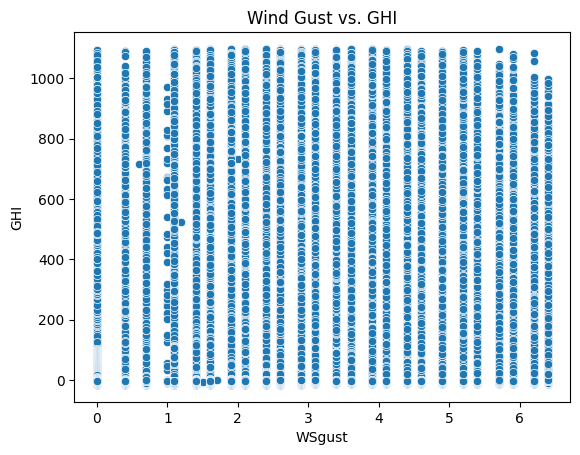

In [22]:
sns.scatterplot(data=df, x='WSgust', y='GHI')
plt.title('Wind Gust vs. GHI')
plt.show()


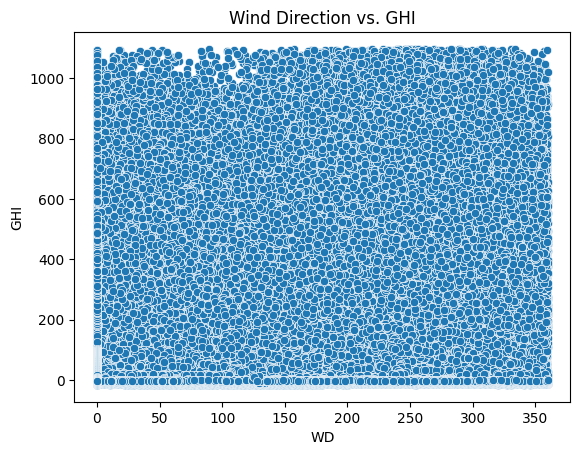

In [23]:
sns.scatterplot(data=df, x='WD', y='GHI')
plt.title('Wind Direction vs. GHI')
plt.show()


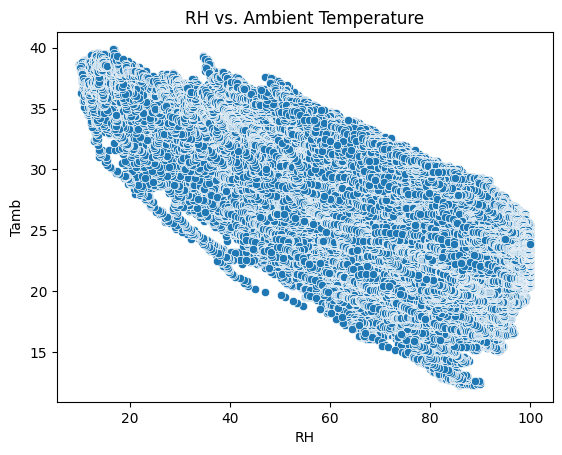

In [24]:
sns.scatterplot(data=df, x='RH', y='Tamb')
plt.title('RH vs. Ambient Temperature')
plt.show()


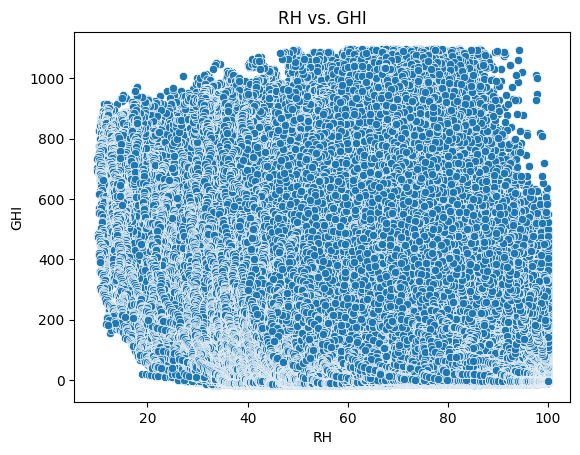

In [25]:
sns.scatterplot(data=df, x='RH', y='GHI')
plt.title('RH vs. GHI')
plt.show()


# Wind & Distribution Analysis

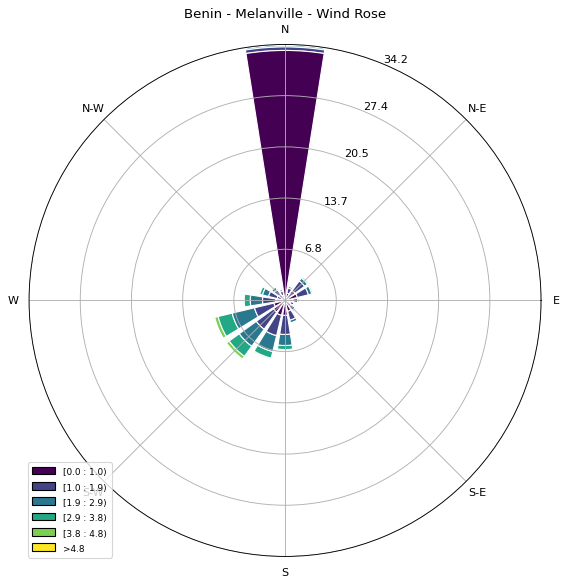

In [26]:
ws = df['WS']
wd = df['WD']

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("Benin - Melanville - Wind Rose")
plt.show()

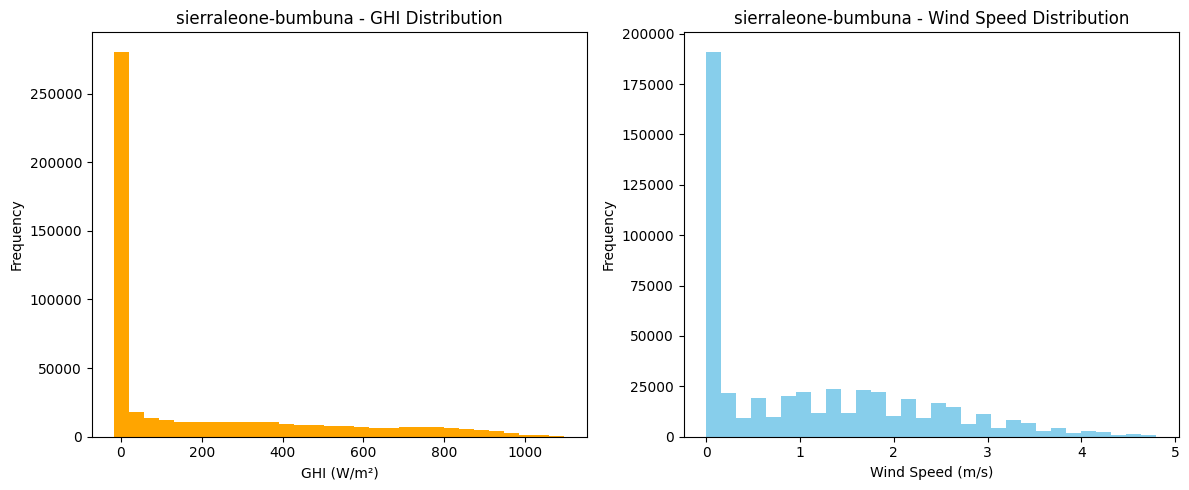

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['GHI'], bins=30, color='orange')
plt.title("sierraleone-bumbuna - GHI Distribution")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Frequency")

# WS
plt.subplot(1, 2, 2)
plt.hist(df['WS'], bins=30, color='skyblue')
plt.title("sierraleone-bumbuna - Wind Speed Distribution")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Temprature analysis

<Axes: xlabel='RH', ylabel='Tamb'>

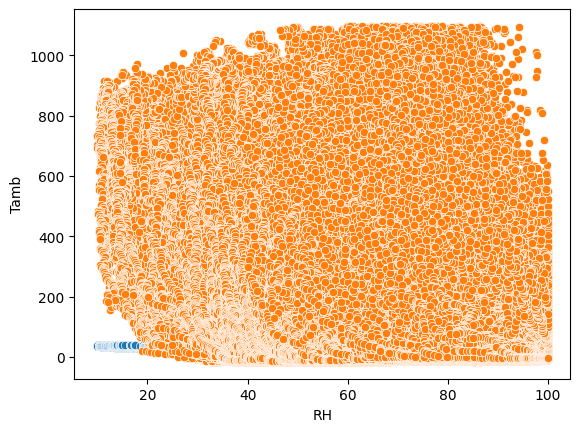

In [28]:

sns.scatterplot(data=df, x='RH', y='Tamb')
sns.scatterplot(data=df, x='RH', y='GHI')

# Bubble Chart

Text(0.5, 1.0, 'GHI vs. Tamb with RH Bubble Size')

/home/eyuleo/Desktop/solar-challenge-week1/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/eyuleo/Desktop/solar-challenge-week1/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


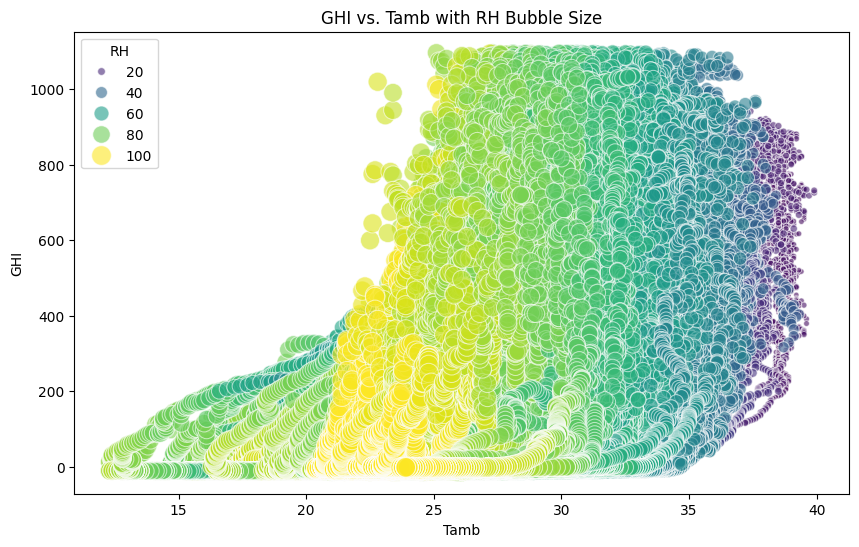

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Tamb', y='GHI',
    size='RH',  # or 'BP'
    hue='RH',
    palette='viridis',
    sizes=(10, 200),
    alpha=0.6
)
plt.title('GHI vs. Tamb with RH Bubble Size')